# Estudo sobre o treinamento de classificadores

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
%autosave 300
%matplotlib notebook

Autosaving every 300 seconds


In [108]:
# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('143k_std.csv')

In [33]:
from sklearn.model_selection import train_test_split

target_col = dataset.shape[1]-1

X = dataset.iloc[:, :target_col]
y = list(map(int, dataset.iloc[:, target_col].values))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def test_model(clf, X_test, y_test):
    print('\nClassification Report:')
    test_time = time()
    y_pred = clf.predict(X_test)
    print('Prediciton time: {:.3f}s'.format(time() - test_time))
    print('\n', classification_report(y_test, y_pred))
    
    print('\nAccuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    
    print('\nConfusion Matrix:')
    print('\n', confusion_matrix(y_test, y_pred),'\n\n')

def train_model(model, parameters, scores, X_train, X_test, y_train, y_test, cv=5, name='model'):
    clfs = []
    for score in scores:
        print('Training {} for {}'.format(name, score))
        train_time = time()
        clf = GridSearchCV(model, parameters, cv=cv, scoring=score)
        clf.fit(X_train, y_train)
        print('Finished Traininig in {:.3f}s'.format(time() - train_time))

        print('Best parameters found:')
        print(clf.best_params_)
        test_model(clf, X_test, y_test)
        clfs.append((score, clf.best_params_, clf))
    
    return clfs

## Extra Trees

In [107]:
from sklearn.ensemble import ExtraTreesClassifier

parameters = [
    {'n_estimators': [target_col, 100], 'max_features':[0.75,0.8,0.85,0.9], 'n_jobs':[-1]}
]

scores = ['f1_macro', 'f1_micro','accuracy']

et_clfs = train_model(ExtraTreesClassifier(),
                   parameters,
                   scores,
                   X_train,
                   X_test,
                   y_train,
                   y_test,
                   name='ExtraTrees'
                  )

# clf = ExtraTreesClassifier(n_estimators=dataset.shape[1]-1, max_features=0.75, n_jobs=-1)

Training ExtraTrees for f1_macro
Finished Traininig in 439.453s
Best parameters found:
{'max_features': 0.9, 'n_estimators': 100, 'n_jobs': -1}

Classification Report:
Prediciton time: 0.857s

              precision    recall  f1-score   support

          1       0.95      0.93      0.94      8357
          2       0.96      0.96      0.96     15132
          3       0.98      0.98      0.98     11434
          4       0.98      0.99      0.99      3343
          5       0.98      0.99      0.98      6393
          6       0.97      0.97      0.97      6864
          7       0.98      0.99      0.99      5724

avg / total       0.97      0.97      0.97     57247


Confusion Matrix:

 [[ 7781   474     2     0    19     4    77]
 [  336 14559    63     1   111    44    18]
 [    1    11 11245    52     8   117     0]
 [    0     0    24  3313     0     6     0]
 [    0    41     8     0  6334    10     0]
 [    0    20   133    15     4  6692     0]
 [   30     3     0     0     0    

## Resultados
Visto o resultado de 97%, podemos ter certo ceticismo, já que na literatura podemos verificar apenas o resultado de 71%.

Sendo assim, verificamos a quantidade e a distribuição das classes no conjunto de dados para avaliação. Visto que, dependendo da distribuição das classes podemos experenciar diferentes resultados.

Pode-se notar que o conjunto de dados para validação está distribuido de forma satisfatória, porém por desencargo de consciência podemos testar o modelo para as amostras retiradas na fase de modelagem.

In [102]:
def plot_multbar(bars, title='', xlabel='', ylabel=''):
    fig, ax = plt.subplots()
    ind = np.arange(1,len(bars)+1)
    plt.bar(ind, bars)
    ax.set_xticks(ind)
    ax.set_title('{}'.format(title))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

[8357, 15132, 11434, 3343, 6393, 6864, 5724]


<IPython.core.display.Javascript object>


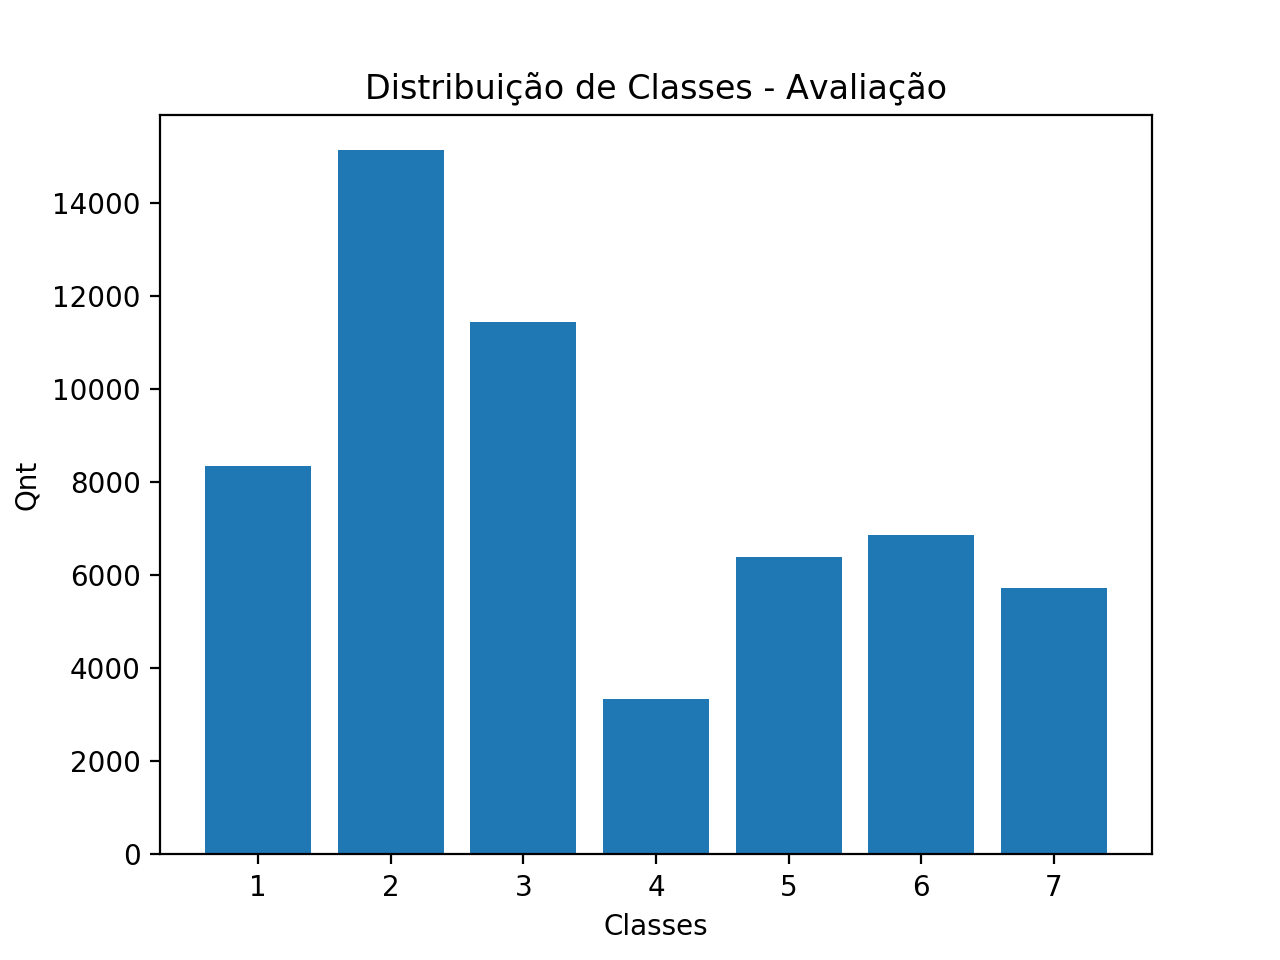

In [103]:
target_sums = [y_test.count(i) for i in range(1, 8)]
print(target_sums)
plot_multbar(target_sums, 'Distribuição de Classes - Avaliação', 'Classes', 'Qnt')

## Testando para classes 1 e 2
Esse teste é realizado tendo em mente que as duas classes são as que mais se sobrepõem dentro do domínio.

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

ssc = joblib.load('stdscaler.pkl')

def pre_process(dataset):
    try:
        dataset = dataset.drop(['Soil7','Soil8','Soil15'], axis=1)
    except Exception as e:
        print(e)
    
    y = dataset.loc[:, 'Target'].values
    X = dataset.iloc[:, :-1].values

    X = ssc.transform(X[:, 0:10])
    X = np.concatenate((X, dataset.iloc[:, 10:-1].values), axis=1)
    
    return X, y
    

In [117]:
dataset_val = pd.read_csv('1_2_val.csv')
X_val, y_val = pre_process(dataset_val)

In [127]:
X_val = np.concatenate((X_val, X_test), axis=0)
y_val = np.concatenate((y_val, y_test), axis=0)

In [128]:
for s, p, clf in et_clfs:
    print('\nTesting ET - {}'.format(p))
    test_model(clf, X_val, y_val)


Testing ET - {'max_features': 0.9, 'n_estimators': 100, 'n_jobs': -1}

Classification Report:
Prediciton time: 6.656s

              precision    recall  f1-score   support

          1       0.89      0.84      0.86    194436
          2       0.90      0.86      0.88    266948
          3       0.67      0.98      0.80     11434
          4       0.98      0.99      0.98      3343
          5       0.49      0.99      0.65      6393
          6       0.59      0.97      0.74      6864
          7       0.47      0.99      0.64      5724

avg / total       0.88      0.86      0.87    495142


Accuracy: 0.863

Confusion Matrix:

 [[163218  24419     98      0   1081    283   5337]
 [ 19880 230863   5255      6   5609   4193   1142]
 [     1     11  11245     52      8    117      0]
 [     0      0     24   3313      0      6      0]
 [     0     41      8      0   6334     10      0]
 [     0     20    133     15      4   6692      0]
 [    30      3      0      0      0      0   569

## Resultados
Com esse teste podemos notar que as classes 1 e 2 estão sobrepostas, sendo dificil classifica-las. Porém, mesmo com essa dificuldade conseguiu-se um resultado de 86% de acurácia ao final, uma melhora de 15%.

# 50-50 _Dataset_

Esse _dataset_ tenta melhorar a acurácia para as classes 1 e 2, aumentando o número de amostras dessas classes para treinamento.

In [129]:
dataset_50 = pd.read_csv('50-50_std.csv')

In [132]:
from sklearn.model_selection import train_test_split

target_col = dataset_50.shape[1]-1

X = dataset_50.iloc[:, :target_col]
y = list(map(int, dataset_50.iloc[:, target_col].values))

X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X, y, test_size=0.4)

In [133]:
from sklearn.ensemble import ExtraTreesClassifier

parameters = [
    {'n_estimators': [target_col, 100], 'max_features':[0.75,0.8,0.85,0.9], 'n_jobs':[-1]}
]

scores = ['f1_macro', 'f1_micro','accuracy']

et_clfs_50 = train_model(ExtraTreesClassifier(),
                   parameters,
                   scores,
                   X_train_50,
                   X_test_50,
                   y_train_50,
                   y_test_50,
                   name='ExtraTrees'
                  )

Training ExtraTrees for f1_macro
Finished Traininig in 714.502s
Best parameters found:
{'max_features': 0.9, 'n_estimators': 100, 'n_jobs': -1}

Classification Report:
Prediciton time: 1.688s

              precision    recall  f1-score   support

          1       0.94      0.92      0.93     15596
          2       0.93      0.93      0.93     18639
          3       0.96      0.98      0.97     14517
          4       0.90      0.87      0.89      1110
          5       0.94      0.94      0.94      3772
          6       0.95      0.95      0.95      6882
          7       0.98      0.99      0.98      8181

avg / total       0.95      0.95      0.95     68697


Accuracy: 0.946

Confusion Matrix:

 [[14303  1068     1     0    44     4   176]
 [  840 17384   126     0   185    90    14]
 [    0    27 14174    81    12   223     0]
 [    0     0   104   971     0    35     0]
 [   12   132    49     0  3558    20     1]
 [    3    17   289    26     2  6545     0]
 [   83    16     

In [134]:
dataset_val_50 = pd.read_csv('50-50_val.csv')
X_val_50, y_val_50 = pre_process(dataset_val)
X_val_50 = np.concatenate((X_val_50, X_test_50), axis=0)
y_val_50 = np.concatenate((y_val_50, y_test_50), axis=0)
for s, p, clf in et_clfs_50:
    print('\nTesting ET 50-50 - {}'.format(p))
    test_model(clf, X_val_50, y_val_50)


Testing ET 50-50 - {'max_features': 0.9, 'n_estimators': 100, 'n_jobs': -1}

Classification Report:
Prediciton time: 9.491s

              precision    recall  f1-score   support

          1       0.94      0.92      0.93    201675
          2       0.95      0.94      0.94    270455
          3       0.87      0.98      0.92     14517
          4       0.90      0.87      0.89      1110
          5       0.57      0.94      0.71      3772
          6       0.79      0.95      0.86      6882
          7       0.78      0.99      0.87      8181

avg / total       0.94      0.93      0.93    506592


Accuracy: 0.934

Confusion Matrix:

 [[185850  13424     30      0    314     92   1965]
 [ 10867 253940   1634      0   2301   1409    304]
 [     0     27  14174     81     12    223      0]
 [     0      0    104    971      0     35      0]
 [    12    132     49      0   3558     20      1]
 [     3     17    289     26      2   6545      0]
 [    83     16      0      0      2      0

---

# Testando para todos os _datasets_

In [142]:
datasets_names = ['143k', '50-50', '60-40', '70-30', 'All']

datasets_train = []
datasets_test = []
for name in datasets_names:
    datasets_train.append(pd.read_csv('{}_std.csv'.format(name)))
    datasets_test.append(pd.read_csv('{}_val.csv'.format(name)))


In [143]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

parameters = [
    {'n_estimators': [target_col, 100], 'max_features':[0.75,0.8,0.85,0.9], 'n_jobs':[-1]}
]

scores = ['f1_macro', 'f1_micro','accuracy']



for d_train, d_test, name in zip(datasets_train, datasets_test, datasets_names):
    print('\nTrain for dataset: {}'.format(name))
    
    target_col = d_train.shape[1]-1

    X = d_train.iloc[:, :target_col]
    y = list(map(int, d_train.iloc[:, target_col].values))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    
    X_val, y_val = pre_process(d_test)
    X_test = np.concatenate((X_val, X_test), axis=0)
    y_test = np.concatenate((y_val, y_test), axis=0)
    
    clfs = train_model(ExtraTreesClassifier(),
                   parameters,
                   scores,
                   X_train,
                   X_test,
                   y_train,
                   y_test,
                   name='ExtraTrees - {}'.format(name)
                  )


Train for dataset: 143k
Training ExtraTrees - 143k for f1_macro
Finished Traininig in 391.480s
Best parameters found:
{'max_features': 0.85, 'n_estimators': 100, 'n_jobs': -1}

Classification Report:
Prediciton time: 5.853s

              precision    recall  f1-score   support

          1       0.89      0.84      0.86    194482
          2       0.90      0.86      0.88    266862
          3       0.66      0.98      0.79     11303
          4       0.98      0.99      0.98      3341
          5       0.49      0.99      0.65      6464
          6       0.59      0.98      0.74      6973
          7       0.46      1.00      0.63      5717

avg / total       0.88      0.86      0.86    495142


Accuracy: 0.861

Confusion Matrix:

 [[163095  24243    115      0   1109    318   5602]
 [ 20988 229698   5398      9   5551   4270    948]
 [     3      6  11125     53     10    106      0]
 [     0      0     25   3296      0     20      0]
 [     2     44     18      0   6393      7    


 [[164633  10743     11      0    234     69   1405]
 [  8490 228307   1278      0   1584    913    254]
 [     2     51  13966     61     18    208      0]
 [     0      0     84    931      0     34      0]
 [    14    152     39      0   3512     13      1]
 [     4     32    258     27      8   6578      0]
 [    94     15      0      0      2      0   8182]] 


Training ExtraTrees - 60-40 for accuracy
Finished Traininig in 818.508s
Best parameters found:
{'max_features': 0.9, 'n_estimators': 100, 'n_jobs': -1}

Classification Report:
Prediciton time: 6.670s

              precision    recall  f1-score   support

          1       0.95      0.93      0.94    177095
          2       0.95      0.95      0.95    240826
          3       0.89      0.98      0.93     14306
          4       0.91      0.89      0.90      1049
          5       0.65      0.94      0.77      3731
          6       0.84      0.95      0.89      6907
          7       0.83      0.99      0.90      8293

av

### Resultados Parciais
Após executar o treinamento para todos os _datasets_ gerados, encontramos o melhor resultado, de **95.6%** de acurácia, para o _dataset_ completo. Porém, para o _dataset_ onde as duas primeiras classes representam 70% do total, foi encontrado um resultado de **95.5%**. Visto que o último é avaliado com um conjunto de avaliação significantemente maior, é mais seguro o utilizarmos como modelo final. 

Portanto, utilizamos desse modelo para realizar ajustes finos e tentar melhorar o resultado final.

### Teste para *n*_*estimators* maior que 100

In [146]:
parameters = [
    {'n_estimators': [100, 150, 200], 'max_features':[0.85,0.9,0.95], 'n_jobs':[-1]}
]

scores = ['f1_macro', 'f1_micro','accuracy']
d_train = datasets_train[3] # 70-30
d_test = datasets_test[3]
name = datasets_names[3]

print('\nTrain for dataset: {}'.format(name))

target_col = d_train.shape[1]-1

X = d_train.iloc[:, :target_col]
y = list(map(int, d_train.iloc[:, target_col].values))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

X_val, y_val = pre_process(d_test)
X_test = np.concatenate((X_val, X_test), axis=0)
y_test = np.concatenate((y_val, y_test), axis=0)

clfs = train_model(ExtraTreesClassifier(),
               parameters,
               scores,
               X_train,
               X_test,
               y_train,
               y_test,
               name='ExtraTrees - {}'.format(name)
              )


Train for dataset: 70-30
Training ExtraTrees - 70-30 for f1_macro
Finished Traininig in 2754.610s
Best parameters found:
{'max_features': 0.95, 'n_estimators': 200, 'n_jobs': -1}

Classification Report:
Prediciton time: 12.941s

              precision    recall  f1-score   support

          1       0.96      0.94      0.95    157947
          2       0.96      0.96      0.96    217243
          3       0.92      0.97      0.95     14132
          4       0.93      0.88      0.91      1093
          5       0.75      0.93      0.83      3739
          6       0.90      0.95      0.92      6853
          7       0.89      0.98      0.93      8264

avg / total       0.95      0.95      0.95    409271


Accuracy: 0.954

Confusion Matrix:

 [[149168   7760      6      0    140     35    838]
 [  6393 208550    725      0   1013    423    139]
 [     1     82  13777     51     17    204      0]
 [     0      0     82    963      0     48      0]
 [    11    219     36      0   3459     14

#### Comentários
Vimos que apesar do aumento do *n*_*estimators* não houve um aumento significativo no resultado final. 

Sendo assim, isso levanta uma dúvida: **"Será que existe um *n*_*estimators* menor que mantenha o resultado de 95%?"**

### Teste para *n*_*estimators* igual e menor que o número de _features_

In [161]:
parameters = [
    {'n_estimators': [40, 45, target_col], 'max_features':[0.85,0.9,0.95,1], 'n_jobs':[-1]}
]

scores = ['f1_macro', 'f1_micro','accuracy']
d_train = datasets_train[3] # 70-30
d_test = datasets_test[3]
name = datasets_names[3]

print('\nTrain for dataset: {}'.format(name))

target_col = d_train.shape[1]-1

X = d_train.iloc[:, :target_col]
y = list(map(int, d_train.iloc[:, target_col].values))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

X_val, y_val = pre_process(d_test)
X_test = np.concatenate((X_val, X_test), axis=0)
y_test = np.concatenate((y_val, y_test), axis=0)

clfs_min_nest = train_model(ExtraTreesClassifier(),
               parameters,
               scores,
               X_train,
               X_test,
               y_train,
               y_test,
               name='ExtraTrees - {}'.format(name)
              )


Train for dataset: 70-30
Training ExtraTrees - 70-30 for f1_macro
Finished Traininig in 1120.444s
Best parameters found:
{'max_features': 0.9, 'n_estimators': 51, 'n_jobs': -1}

Classification Report:
Prediciton time: 4.667s

              precision    recall  f1-score   support

          1       0.96      0.94      0.95    157689
          2       0.96      0.96      0.96    217162
          3       0.92      0.98      0.95     14162
          4       0.92      0.89      0.90      1090
          5       0.76      0.92      0.83      3888
          6       0.90      0.94      0.92      7024
          7       0.89      0.98      0.94      8256

avg / total       0.95      0.95      0.95    409271


Accuracy: 0.954

Confusion Matrix:

 [[148640   8017     12      0    146     42    832]
 [  6284 208622    699      0    981    436    140]
 [     0     69  13828     55     13    197      0]
 [     0      0     95    965      0     30      0]
 [    16    262     34      0   3562     14   

In [162]:
pd.DataFrame(clfs_min_nest[1][2].cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_features,param_n_estimators,param_n_jobs,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,21.698520,0.398194,0.947834,1.0,0.85,40,-1,"{'max_features': 0.85, 'n_estimators': 40, 'n_...",9,0.946202,...,0.947479,1.0,0.948322,1.0,0.948726,1.0,1.509012,0.045673,0.000916,0.0
1,17.430413,0.382023,0.948207,1.0,0.85,45,-1,"{'max_features': 0.85, 'n_estimators': 45, 'n_...",8,0.946232,...,0.947071,1.0,0.949399,1.0,0.949629,1.0,1.192426,0.056983,0.001333,0.0
2,19.567503,0.458790,0.948253,1.0,0.85,51,-1,"{'max_features': 0.85, 'n_estimators': 51, 'n_...",6,0.947804,...,0.946518,1.0,0.948584,1.0,0.949367,1.0,2.615536,0.045648,0.001011,0.0
3,15.798809,0.333966,0.948213,1.0,0.9,40,-1,"{'max_features': 0.9, 'n_estimators': 40, 'n_j...",7,0.947716,...,0.946402,1.0,0.948991,1.0,0.950066,1.0,1.313390,0.003249,0.001239,0.0
4,17.137032,0.338014,0.948812,1.0,0.9,45,-1,"{'max_features': 0.9, 'n_estimators': 45, 'n_j...",3,0.948007,...,0.947653,1.0,0.950068,1.0,0.949716,1.0,0.255022,0.005749,0.000941,0.0
5,19.421373,0.436335,0.948865,1.0,0.9,51,-1,"{'max_features': 0.9, 'n_estimators': 51, 'n_j...",2,0.948066,...,0.948323,1.0,0.949341,1.0,0.949600,1.0,0.319634,0.002438,0.000586,0.0
6,15.756043,0.342739,0.948609,1.0,0.95,40,-1,"{'max_features': 0.95, 'n_estimators': 40, 'n_...",4,0.948735,...,0.947537,1.0,0.949748,1.0,0.949250,1.0,0.083579,0.005854,0.000845,0.0
7,18.118283,0.341180,0.948422,1.0,0.95,45,-1,"{'max_features': 0.95, 'n_estimators': 45, 'n_...",5,0.948298,...,0.947770,1.0,0.948351,1.0,0.949105,1.0,0.314696,0.006299,0.000433,0.0
8,20.235556,0.390792,0.948970,1.0,0.95,51,-1,"{'max_features': 0.95, 'n_estimators': 51, 'n_...",1,0.948182,...,0.947915,1.0,0.949515,1.0,0.950444,1.0,0.120122,0.047527,0.000920,0.0
9,3.816082,0.472003,0.898522,1.0,1,40,-1,"{'max_features': 1, 'n_estimators': 40, 'n_job...",12,0.896102,...,0.895394,1.0,0.899817,1.0,0.900306,1.0,0.121977,0.048016,0.002306,0.0


## Resultados Finais
Visto que o ajuste fino e o incremento no número de estimadores não causou mudanças significativas nas métricas (mudança de 0.001% para acurácia), foi escolhido o modelo treinado anteriormente.

Para o modelo final foi selecionado o algoritmo _Extra Trees_, com os parâmetros: `{'max_features': 0.9, 'n_estimators': 100, 'n_jobs': -1}`, que alcancou uma acurácia de **95.5%**, _F1 score_ e _recall_ de **95%** e precisão de **96%**.

In [158]:
from sklearn.externals import joblib

parameters = [
    {'n_estimators': [51], 'max_features':[0.95], 'n_jobs':[-1]}
]

scores = ['f1_micro']
d_train = datasets_train[3] # 70-30
d_test = datasets_test[3]
name = datasets_names[3]

print('\nTrain for dataset: {}'.format(name))

target_col = d_train.shape[1]-1

X = d_train.iloc[:, :target_col]
y = list(map(int, d_train.iloc[:, target_col].values))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

X_val, y_val = pre_process(d_test)
X_test = np.concatenate((X_val, X_test), axis=0)
y_test = np.concatenate((y_val, y_test), axis=0)

final = train_model(ExtraTreesClassifier(),
               parameters,
               scores,
               X_train,
               X_test,
               y_train,
               y_test,
               name='ExtraTrees - {}'.format(name)
              )

joblib.dump(final[0][2].best_estimator_,'ExtraTree09100.pkl', compress=3)


Train for dataset: 70-30
Training ExtraTrees - 70-30 for f1_micro
Finished Traininig in 173.882s
Best parameters found:
{'max_features': 0.95, 'n_estimators': 51, 'n_jobs': -1}

Classification Report:
Prediciton time: 4.192s

              precision    recall  f1-score   support

          1       0.96      0.94      0.95    157681
          2       0.96      0.96      0.96    217013
          3       0.92      0.97      0.95     14386
          4       0.92      0.88      0.90      1127
          5       0.74      0.92      0.82      3813
          6       0.90      0.95      0.92      6936
          7       0.89      0.98      0.93      8315

avg / total       0.95      0.95      0.95    409271


Accuracy: 0.954

Confusion Matrix:

 [[148893   7716      9      0    147     28    888]
 [  6468 208141    753      0   1037    476    138]
 [     1     80  14025     53     19    208      0]
 [     0      0    107    990      0     30      0]
 [    21    219     32      0   3527     13   

['ExtraTree09100.pkl']

In [165]:
from sklearn.metrics import roc_curve, auc

def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 
                        'tf' : pd.Series(tpr-(1-fpr), index=i), 
                        'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    
    return list(roc_t['threshold']), roc_t['fpr'], roc_t['tpr']

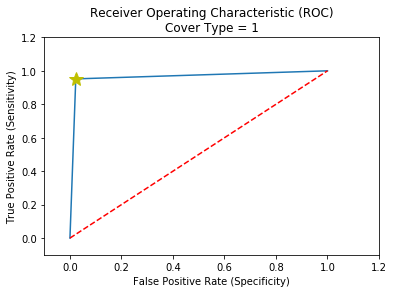

AUC: 0.9646


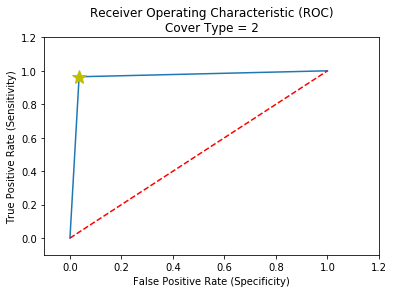

AUC: 0.9645


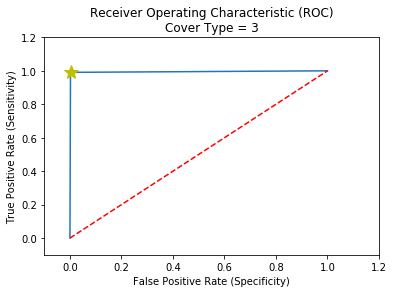

AUC: 0.9943


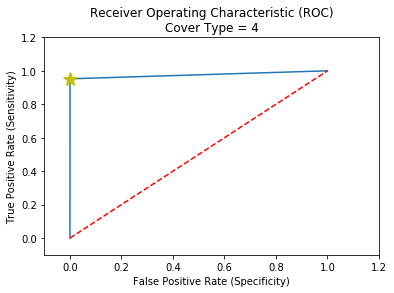

AUC: 0.9761


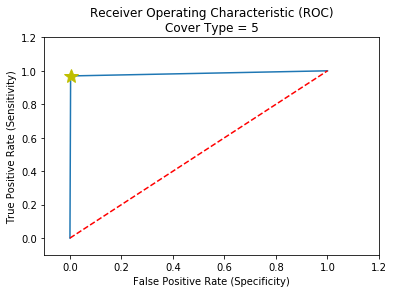

AUC: 0.9834


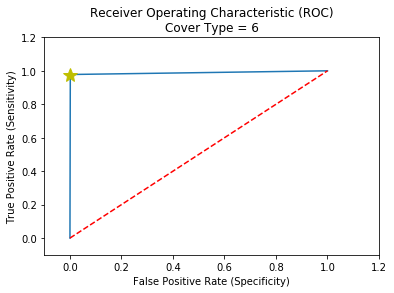

AUC: 0.9883


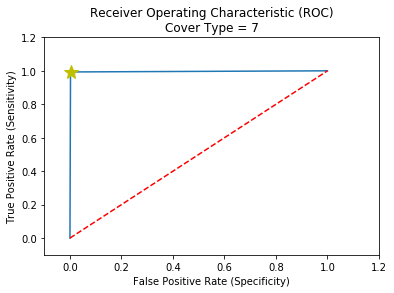

AUC: 0.9955


In [182]:
%matplotlib inline
y_pred = final[0][2].predict(X_test)

for i in range(1, 8):
    y_test_i = y_test.copy() 
    y_test_i[y_test_i != i] = 0
    y_test_i[y_test_i == i] = 1
    
    y_pred_i = y_pred.copy()
    y_pred_i[y_pred_i != i] = 0
    y_pred_i[y_pred_i == i] = 1

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_i, y_pred_i)
    plt.title('Receiver Operating Characteristic (ROC)\nCover Type = {}'.format(i))
    plt.plot(false_positive_rate, true_positive_rate)
    optimal_threshold = Find_Optimal_Cutoff(y_test_i, y_pred_i)
    plt.plot(optimal_threshold[1].iloc[0], optimal_threshold[2].iloc[0], 'y*', ms=15)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.xlabel('False Positive Rate (Specificity)')
    plt.show()

    roc_auc = auc(false_positive_rate, true_positive_rate)
    print('AUC: {:.4f}'.format(roc_auc))